# Find Most Important Features

Using a sum normalization, we try to find the most important features in the data set.

## Metaboloma

1. Read data set
2. Set colors for each class in data set
3. Fill the Nan Value
4. Normalization with Sum
5. Drop Outliers
6. Define X and Y
7. Compute mean and std in X

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.stats import chi2

#   1
# Read data set
data_metaboloma_transpose = pd.read_excel("../../DataSet PAscale/Metaboloma.xlsx")
data_metaboloma_transpose

data_metaboloma = data_metaboloma_transpose.T

data_metaboloma.columns = data_metaboloma_transpose["Sample"]

data_metaboloma = data_metaboloma.iloc[1:]

data_metaboloma.columns = list(data_metaboloma.columns)

df_y_metaboloma = data_metaboloma["Label"].iloc[1:]

mz_metaboloma = data_metaboloma.iloc[0:1,1:]

df_y_qc_metaboloma = data_metaboloma["Label"].iloc[1:5]

df_x_metaboloma = data_metaboloma.iloc[1:,1:]

df_qc_metaboloma = data_metaboloma.iloc[1:5]

name_samples_metaboloma = df_x_metaboloma.transpose().columns

df_x_metaboloma

#   2
#Set colors for each class in data set
# color mapping to use in plot
color_mapping = {
    'LC': 'red',
    'MC': 'green',
    'HC' : 'orange',
    'QC' : 'purple'
}
colors = [color_mapping[label] for label in df_y_metaboloma]

#   3
# Fill the Nan Value
df_x_metaboloma_original = df_x_metaboloma.copy()
for column in df_x_metaboloma.columns:
    df_x_metaboloma.loc[:,column] = df_x_metaboloma[column].fillna((np.nanmin(df_x_metaboloma[column]))/5)
    

#   4
# Normalization with MIN-MAX
min = df_x_metaboloma_original.min(axis=1,skipna=True)
max = df_x_metaboloma_original.max(axis=1,skipna=True)
df_minus_min = df_x_metaboloma.sub(min,axis=0)
max_minus_min = max.sub(min,axis=0)

df_x_metaboloma_minmax = df_minus_min.div(max_minus_min,axis=0)

pca_view = PCA(n_components=2)
scores_view = pca_view.fit_transform(df_x_metaboloma_minmax,df_y_metaboloma)

#   5
# Drop outlier
drop = []
alpha = 0.05
threshold_distance_mahalanobis = chi2.ppf(1 - alpha, df = 2)
threshold_distance_mahalanobis
# LC
lc = scores_view[4:73,:]

mean_lc = np.mean(lc,axis=0)
cov_matrix = np.cov(lc,rowvar=False)

mahalanobis_distance_lc = []

for point in lc:
    diff = point - mean_lc
    distance = np.sqrt(np.dot(np.dot(diff, np.linalg.inv(cov_matrix)), diff))
    mahalanobis_distance_lc.append(distance)

outlier_lc = pd.DataFrame({"Sample":df_x_metaboloma_minmax.index[4:73],"outlier":mahalanobis_distance_lc}).sort_values(by="outlier",ascending=False)
outlier_lc

mean_out_lc = outlier_lc["outlier"].mean(axis=0)
temp = []
for sample,elem in outlier_lc.values:
    if elem > threshold_distance_mahalanobis:
        drop.append(sample)
        temp.append(sample)

outlier_lc = outlier_lc.drop(outlier_lc[outlier_lc["Sample"].isin(temp)].index)   

# MC
mc = scores_view[73:83,:]

mean_mc = np.mean(mc,axis=0)
cov_matrix = np.cov(mc,rowvar=False)

mahalanobis_distance_mc = []

for point in mc:
    diff = point - mean_mc
    distance = np.sqrt(np.dot(np.dot(diff, np.linalg.inv(cov_matrix)), diff))
    mahalanobis_distance_mc.append(distance)

outlier_mc = pd.DataFrame({"Sample":df_x_metaboloma_minmax.index[73:83],"outlier":mahalanobis_distance_mc}).sort_values(by="outlier",ascending=False)
outlier_mc

mean_out_mc = outlier_mc["outlier"].mean(axis=0)
temp = []
for sample,elem in outlier_mc.values:
    if elem > threshold_distance_mahalanobis:
        drop.append(sample)
        temp.append(sample)
        
outlier_mc = outlier_mc.drop(outlier_mc[outlier_mc["Sample"].isin(temp)].index)

#HC
hc = scores_view[83:106,:]

mean_hc = np.mean(hc,axis=0)
cov_matrix = np.cov(hc,rowvar=False)

mahalanobis_distance_hc = []

for point in hc:
    diff = point - mean_hc
    distance = np.sqrt(np.dot(np.dot(diff, np.linalg.inv(cov_matrix)), diff))
    mahalanobis_distance_hc.append(distance)
    

outlier_hc = pd.DataFrame({"Sample":df_x_metaboloma_minmax.index[83:106],"outlier":mahalanobis_distance_hc}).sort_values(by="outlier",ascending=False)
outlier_hc

mean_out_hc = outlier_hc["outlier"].mean(axis=0)

temp = []
for sample,elem in outlier_hc.values:
    if elem > threshold_distance_mahalanobis:
        drop.append(sample)
        temp.append(sample)

outlier_hc = outlier_hc.drop(outlier_hc[outlier_hc["Sample"].isin(temp)].index) 

#   6
# Define X and Y
df_x_metaboloma_minmax_noqc = df_x_metaboloma_minmax.iloc[4:]
df_y_metaboloma_noqc = df_y_metaboloma.iloc[4:]


x_minmax = df_x_metaboloma_minmax_noqc.copy()
y_minmax = df_y_metaboloma_noqc.copy()

x_minmax = x_minmax.drop(drop)
y_minmax = y_minmax.drop(drop)
print(y_minmax.value_counts())

name_x_minmax = x_minmax.transpose().columns

#   7
# Compute the mean and std in X
mean_minmax= x_minmax.mean(axis=0)
std_minmax = x_minmax.std(axis=0)

x_minmax = (x_minmax.sub(mean_minmax,axis=1)).div(std_minmax,axis=1)

Label
LC    69
HC    23
MC    10
Name: count, dtype: int64


## Dimensionality reduction

### Elbow Graph

In [2]:
from sklearn.decomposition import PCA

varianza_spiegata_minmax = []
n_componenti_minmax = np.arange(1, min(x_minmax.shape[0],x_minmax.shape[1]))

for n in n_componenti_minmax:
    pca_elbow = PCA(n_components=n)
    pca_elbow.fit(x_minmax)
    varianza_spiegata_minmax.append(np.sum(pca_elbow.explained_variance_ratio_))

Find the maximum distance between rope and elbow graph

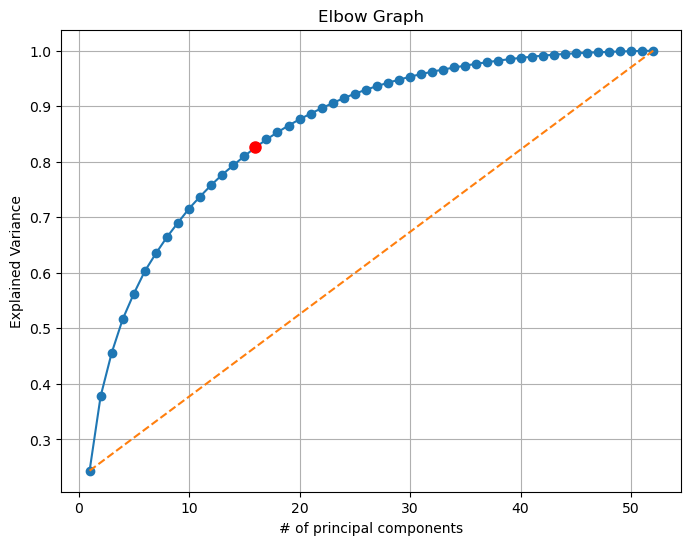

In [3]:
from scipy.spatial.distance import euclidean

points = np.array(list(zip(n_componenti_minmax,varianza_spiegata_minmax)))
points

first_point = points[0]
last_point = points[-1]

chord_length = euclidean(first_point, last_point)
distances = []
for point in points:
    distance = np.abs(np.cross(last_point - first_point, first_point - point)) / chord_length
    distances.append(distance)

max_distance_index = np.argmax(distances)
points[max_distance_index][0]
num_components_pca = int(points[max_distance_index][0])
num_components_pca

plt.figure(figsize=(8, 6))
plt.plot(n_componenti_minmax, varianza_spiegata_minmax, marker='o')
plt.plot([1,len(varianza_spiegata_minmax)],[varianza_spiegata_minmax[0],varianza_spiegata_minmax[-1]], linestyle='--', label="Rope")
plt.plot(points[max_distance_index][0],points[max_distance_index][1], marker='o', markersize=8, color="red", label="Optimal Components")
plt.xlabel('# of principal components')
plt.ylabel('Explained Variance')
plt.title('Elbow Graph')
plt.grid(True)
plt.show()

### PCA

In [4]:
pca_minmax = PCA(n_components=num_components_pca)
pca_minmax_fit= pca_minmax.fit(x_minmax)
x_minmax_pca = pca_minmax_fit.transform(x_minmax)
x_minmax_pca

array([[-4.14665076,  1.50445794,  1.52233597, ..., -2.38253266,
        -1.59925047,  1.33891349],
       [ 0.25964591, -1.33695025,  0.61081616, ..., -1.04093419,
        -0.29926541, -0.15287214],
       [-0.7611712 , -2.47064221,  1.19590856, ...,  0.70552877,
         0.45633797, -1.37930399],
       ...,
       [-7.82328238,  1.92881183, -2.73780455, ...,  1.10721701,
        -1.0579184 , -0.01593392],
       [-4.3188711 ,  0.76713466, -2.45956858, ..., -1.54650622,
        -0.9570588 ,  0.13537269],
       [-4.20732588,  3.88582423, -1.76977345, ...,  0.36515781,
         1.44022485, -1.64731827]])

## Prepare dataframe

In [5]:
from imblearn.over_sampling import BorderlineSMOTE
X_w_minmax = pd.DataFrame(x_minmax_pca)
Y_w_minmax = y_minmax

X_w_minmax.columns = [f'PC{i}' for i in range(X_w_minmax.shape[1])]
X_w_minmax = X_w_minmax.transpose()
X_w_minmax.columns = name_x_minmax
X_w_minmax = X_w_minmax.transpose()

all_performance = []

#ribilanciamento
bls = BorderlineSMOTE(random_state=99)
x,y = bls.fit_resample(X_w_minmax,Y_w_minmax)

## Fit the Logistic Regression model

In [6]:
from sklearn.linear_model import LogisticRegression

FinalModel = LogisticRegression(penalty=None, class_weight='balanced', multi_class='auto',max_iter=10000, n_jobs=4, solver='newton-cg')
    
FinalModel.fit(x, y)

FinalModel

LogisticRegression(class_weight='balanced', max_iter=10000, n_jobs=4,
                   penalty=None, solver='newton-cg')

## Fit the SVM model

In [7]:
from sklearn.svm import SVC
from imblearn.over_sampling import BorderlineSMOTE

SVM_models =  SVC(C=1.0,kernel="linear", gamma="scale")

SVM_models.fit(x,y)

SVM_models

SVC(kernel='linear')

## Fit the RandomForest models

In [8]:
from sklearn.ensemble import RandomForestClassifier

RF_model = RandomForestClassifier(n_estimators=200, random_state=3, max_depth=22, n_jobs=4)
RF_model.fit(x, y)

RF_model

RandomForestClassifier(max_depth=22, n_estimators=200, n_jobs=4, random_state=3)

## Analyze the model

#### Logistic Regression

In [9]:
# weight of model components 
features_importance = pd.DataFrame({"PC": FinalModel.feature_names_in_, "Coefficient": abs(FinalModel.coef_[0])})

name_pc = features_importance.T.columns

features_imp_original = pd.DataFrame({"Feature": x_minmax.columns,**{f"PC{i}":abs(pca_minmax_fit.components_[i])for i in name_pc}})
features_imp_original
temp = features_imp_original.T
temp.columns = x_minmax.columns
temp_2 = temp.T
features_imp_original = temp_2.iloc[:,1:]

out_logistic_regression = np.dot(features_imp_original,(features_importance["Coefficient"] * pca_minmax_fit.explained_variance_ratio_))
out_logistic_regression

most_important_features_lr = pd.DataFrame({"LogisticRegression":out_logistic_regression})
most_important_features_lr.index = features_imp_original.index

most_important_features = pd.DataFrame({"Features":x_minmax.columns,"LogisticRegression":out_logistic_regression})
most_important_features

most_important_features_lr

,LogisticRegression
Aminooctanoic acid,0.233331
Androsterone sulfate,0.226542
Arachidonic acid,0.199553
Arginine,0.230786
Asymmetric dimethylarginine,0.275762
Bilirubin,0.183924
Biliverdin,0.266237
CAR 10:0,0.267187
CAR 10:1,0.277411
CAR 14:1,0.241733


#### SVM

In [10]:
features_importance = pd.DataFrame({"PC": SVM_models.feature_names_in_, "Coefficient": abs(SVM_models.coef_[0])})

features_importance.max(axis=0)

name_pc = features_importance.T.columns

features_imp_original = pd.DataFrame({"Feature": x_minmax.columns,**{f"PC{i}":abs(pca_minmax_fit.components_[i])for i in name_pc}})

temp = features_imp_original.T
temp.columns = x_minmax.columns
temp_2 = temp.T
features_imp_original = temp_2.iloc[:,1:]

out_svm = np.dot(features_imp_original,(features_importance["Coefficient"] * pca_minmax_fit.explained_variance_ratio_))
out_svm

most_important_features_svm = pd.DataFrame({"Features":x_minmax.columns,"SVM":out_svm})
most_important_features_svm.index = features_imp_original.index

most_important_features["SVM"] = out_svm
most_important_features

,Features,LogisticRegression,SVM
0,Aminooctanoic acid,0.233331,0.034891
1,Androsterone sulfate,0.226542,0.033251
2,Arachidonic acid,0.199553,0.030016
3,Arginine,0.230786,0.031769
4,Asymmetric dimethylarginine,0.275762,0.04057
5,Bilirubin,0.183924,0.028516
6,Biliverdin,0.266237,0.037133
7,CAR 10:0,0.267187,0.040141
8,CAR 10:1,0.277411,0.041753
9,CAR 14:1,0.241733,0.033239


#### RandomForest

In [11]:
features_importance = pd.DataFrame({"PC": RF_model.feature_names_in_, "Coefficient": (RF_model.feature_importances_)}).sort_values(by="Coefficient",ascending=False)

features_importance

name_pc = features_importance.T.columns

features_imp_original = pd.DataFrame({"Feature": x_minmax.columns,**{f"PC{i}":abs(pca_minmax_fit.components_[i])for i in name_pc}})

temp = features_imp_original.T
temp.columns = x_minmax.columns
temp_2 = temp.T
features_imp_original = temp_2.iloc[:,1:]
features_imp_original

out_random_forest = np.dot(features_imp_original,(features_importance["Coefficient"] * pca_minmax_fit.explained_variance_ratio_))
out_random_forest

most_important_features_rf = pd.DataFrame({"Feature": x_minmax.columns,"RandomForest":out_random_forest})
most_important_features_rf.index = features_imp_original.index

most_important_features["RandomForest"] = out_random_forest
most_important_features

,Features,LogisticRegression,SVM,RandomForest
0,Aminooctanoic acid,0.233331,0.034891,0.019658
1,Androsterone sulfate,0.226542,0.033251,0.028913
2,Arachidonic acid,0.199553,0.030016,0.011633
3,Arginine,0.230786,0.031769,0.015853
4,Asymmetric dimethylarginine,0.275762,0.04057,0.017077
5,Bilirubin,0.183924,0.028516,0.012672
6,Biliverdin,0.266237,0.037133,0.019408
7,CAR 10:0,0.267187,0.040141,0.021165
8,CAR 10:1,0.277411,0.041753,0.021806
9,CAR 14:1,0.241733,0.033239,0.010182


## Most Important Features
The list is not in priority order.
The order of RandomForest that intersec the SVM and after intersec LogisticRegression is not random, but we choose this order because this is the order of performance of models

In [12]:
file_path = "most_important_features_minmax.xlsx"
MOST_IMP_RF = most_important_features_rf.sort_values(by="RandomForest", ascending=False).iloc[:20]
MOST_IMP_SVM = most_important_features_svm.sort_values(by="SVM", ascending=False).iloc[:20]
MOST_IMP_LR = most_important_features_lr.sort_values(by="LogisticRegression", ascending=False).iloc[:20]

MOST_IMP_FEATURES = pd.DataFrame({"Features":MOST_IMP_RF.index.intersection(MOST_IMP_SVM.index).intersection(MOST_IMP_LR.index)})
MOST_IMP_FEATURES.to_excel(file_path)

most_important_features_tot = pd.DataFrame({"Feature LR":MOST_IMP_LR.index, "Feature SVM":MOST_IMP_SVM.index, "Feature RF":MOST_IMP_RF.index})
most_important_features_tot.to_excel("most_important_features_tot.xlsx")

# most_important_features_tot
MOST_IMP_FEATURES_LIST = MOST_IMP_FEATURES["Features"]
MOST_IMP_FEATURES

,Features
0,Dehydroepiandrosterone sulfate
1,Glycerophosphocholine
2,Methylpyridonecarboxamide
3,Indoxyl sulfate
4,CAR 9:0
5,CAR 3:0
6,CAR 5:1
7,Isoleucylproline
8,Methylguanine
9,CAR 5:0


### Analisi Univariata

In [13]:
feature_1 = pd.DataFrame(x_minmax[MOST_IMP_FEATURES_LIST])
feature_1["Label"] = y_minmax.values
MZ = pd.DataFrame(mz_metaboloma[MOST_IMP_FEATURES_LIST])
len(feature_1.index)
MZ

,Dehydroepiandrosterone sulfate,Glycerophosphocholine,Methylpyridonecarboxamide,Indoxyl sulfate,CAR 9:0,CAR 3:0,CAR 5:1,Isoleucylproline,Methylguanine,CAR 5:0,CAR 10:1,CAR 10:0,CAR 8:0
m/z measured,367.15889,258.11014,153.06585,212.00253,302.23251,218.1381,244.15388,229.15457,166.07248,246.16982,314.23275,316.24831,288.21724


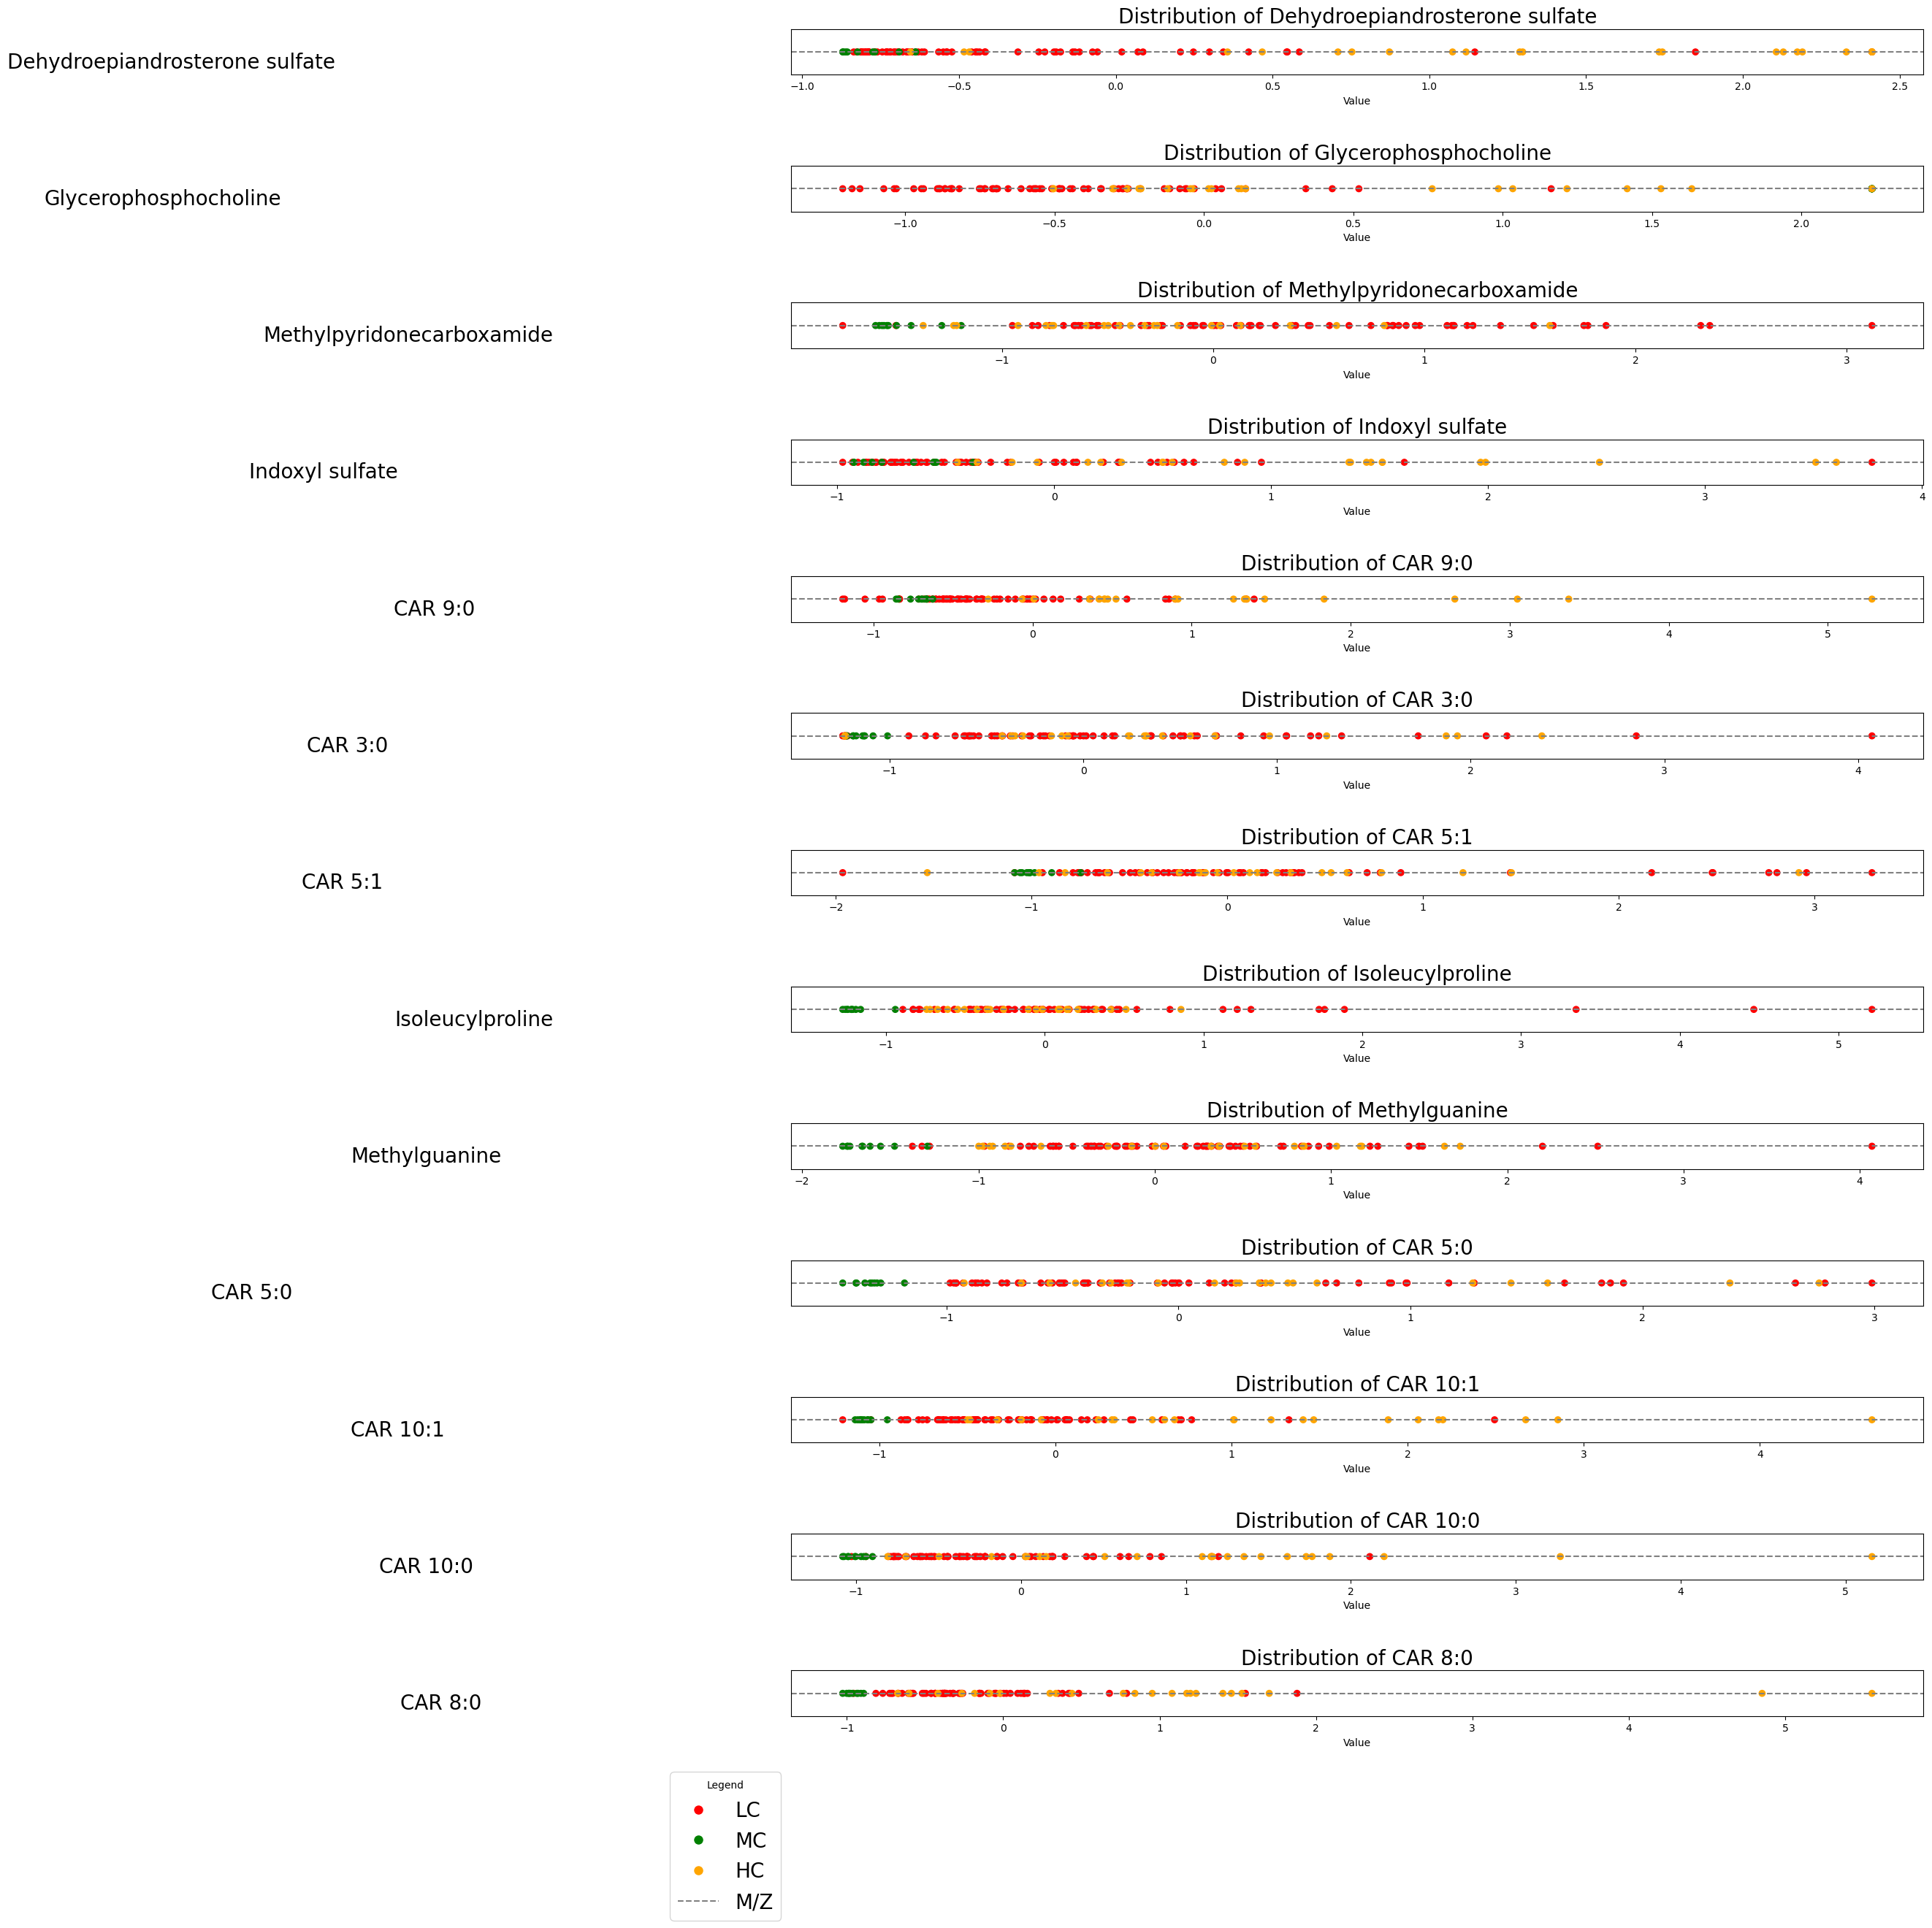

In [14]:
fig, axs = plt.subplots(nrows=len(MOST_IMP_FEATURES_LIST), ncols=1, figsize=(20, 30))

for i, (feature) in enumerate(MOST_IMP_FEATURES_LIST):
    mz = MZ[feature].values
    mz_const = [mz]*len(feature_1.index)
    # Creiamo lo scatter plot per la feature corrente
    axs[i].scatter(feature_1[feature], mz_const, color=[color_mapping[label] for label in feature_1["Label"].values], label='Feature')
    
    # Aggiungiamo una linea orizzontale per il valore costante
    axs[i].axhline(y=mz, color='grey', linestyle='--', label='M/Z')
    axs[i].text(axs[i].get_xlim()[0] - 2.5, mz, feature, color='black', fontsize=20, va = "top")
    
    # Aggiungiamo titoli e legende
    axs[i].set_title(f'Distribution of {feature}', fontsize= 20)
    axs[i].set_xlabel('Value')
    axs[i].set_ylabel('M/Z')
    plt.subplots_adjust(hspace=2) 
    axs[i].get_yaxis().set_visible(False)
    
plt.legend(handles=[
    plt.Line2D([0], [0], marker='o', color='w', label='LC', markerfacecolor='red', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='MC', markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='HC', markerfacecolor='orange', markersize=10),
    plt.Line2D([0], [0], color='grey', label='M/Z', linestyle='--')
], title='Legend', bbox_to_anchor=(0, -1), loc='upper right', fontsize = 20)
plt.show()